In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import seaborn as sns
import scipy

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import joblib


In [2]:
# Load data
data_dir = './'
testcsv = pd.read_csv("./finalproject_test.csv")
traincsv = pd.read_csv("./finalproject_train.csv")
validcsv = pd.read_csv("./finalproject_validation.csv")

# Data preprocessing
X = traincsv.drop(columns=['label', 'file'])
y = traincsv['label']

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Addressing class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Define classifiers (excluding Neural Network and Naive Bayes due to long comp times)
classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Ridge Classifier': RidgeClassifier(),
    'Logistic Regression': LogisticRegression(),
}


Classifier: Decision Tree
Accuracy: 0.9272922636103151
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      1409
           1       0.94      0.92      0.93      1383

    accuracy                           0.93      2792
   macro avg       0.93      0.93      0.93      2792
weighted avg       0.93      0.93      0.93      2792



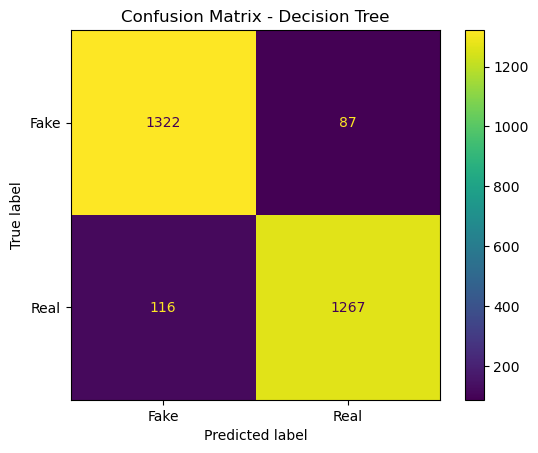

Classifier: Random Forest
Accuracy: 0.9881805157593123
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1409
           1       0.99      0.99      0.99      1383

    accuracy                           0.99      2792
   macro avg       0.99      0.99      0.99      2792
weighted avg       0.99      0.99      0.99      2792



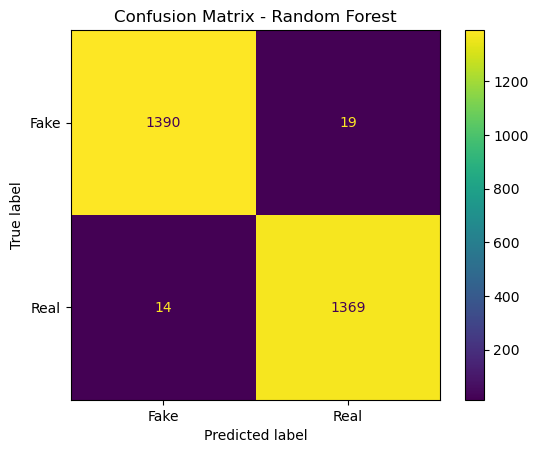

Classifier: Ridge Classifier
Accuracy: 0.8517191977077364
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.87      0.85      1409
           1       0.86      0.84      0.85      1383

    accuracy                           0.85      2792
   macro avg       0.85      0.85      0.85      2792
weighted avg       0.85      0.85      0.85      2792



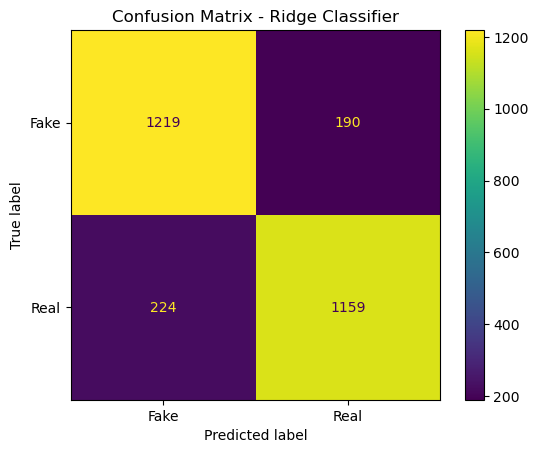

c:\Users\gavin\anaconda3\envs\voice\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classifier: Logistic Regression
Accuracy: 0.8187679083094556
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82      1409
           1       0.83      0.80      0.81      1383

    accuracy                           0.82      2792
   macro avg       0.82      0.82      0.82      2792
weighted avg       0.82      0.82      0.82      2792



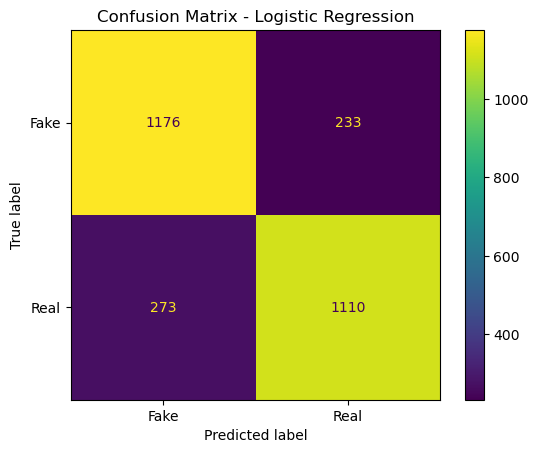

In [16]:
# Train and evaluate classifiers
for name, clf in classifiers.items():
    clf.fit(X_train_res, y_train_res)
    y_pred = clf.predict(X_val)
    print(f"Classifier: {name}")
    print("Accuracy:", accuracy_score(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))
    ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val, display_labels=["Fake", "Real"])
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


In [ ]:
# Hyperparameter tuning for Decision Tree
#2 mins
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), param_grid=param_grid_dt, cv=5, scoring='accuracy')
grid_search_dt.fit(X_train_res, y_train_res)
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)
#Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


Best Parameters for Decision Tree: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [ ]:
# Hyperparameter tuning for RandomForest
#73 mins
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid_rf, cv=5, scoring='accuracy')
grid_search_rf.fit(X_train_res, y_train_res)
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)
#Best Parameters for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}


Best Parameters for RandomForest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 300}


In [8]:
# Export the best model
joblib.dump(grid_search_rf.best_estimator_, 'random_forest_model.pkl')
print("Model exported successfully!")


Model exported successfully!


In [12]:
# Final model evaluation (example with RandomForest)
X_test = testcsv.drop(columns=['label', 'file'])
X_test = imputer.transform(X_test)  # Apply the same imputer to test data
y_test = testcsv['label']

# Load the model
loaded_model = joblib.load('random_forest_model.pkl')

# Make predictions with the loaded model
y_test_pred = loaded_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
print("Test Classification Report:\n", classification_report(y_test, y_test_pred))


Test Accuracy: 0.6452205882352942
Test Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.31      0.47       544
           1       0.59      0.98      0.73       544

    accuracy                           0.65      1088
   macro avg       0.76      0.65      0.60      1088
weighted avg       0.76      0.65      0.60      1088



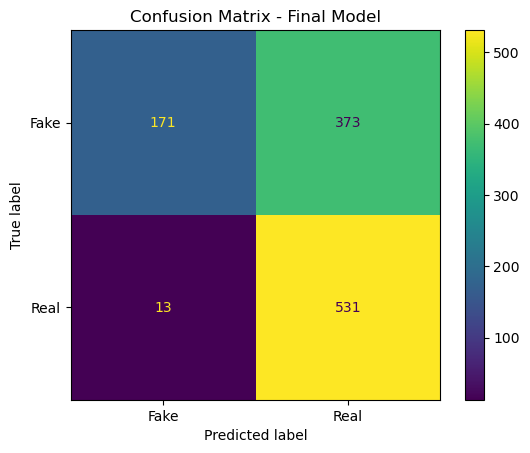

CV Accuracy: 0.99 ± 0.00


In [13]:

# Display confusion matrix
ConfusionMatrixDisplay.from_estimator(loaded_model, X_test, y_test, display_labels=["Fake", "Real"])
plt.title('Confusion Matrix - Final Model')
plt.show()

# Cross-validation for the selected model
cv_scores = cross_val_score(loaded_model, X, y, cv=5, scoring='accuracy')
print("CV Accuracy: {:.2f} ± {:.2f}".format(cv_scores.mean(), cv_scores.std()))

